# MCT4052 Workshop 5f: MIDI Files + LDA + SVM Classifier v3

*Author: Stefano Fasciani, stefano.fasciani@imv.uio.no, Department of Musicology, University of Oslo.*

The notebooks Workshop 5b to 5h integrates a stage of dimensionality reduction with different type of machine learning technique (classification, regression, clustering) on audio or MIDI data. The machine learning techniques included in this set of examples are those from previous workshops.

In [1]:
import numpy as np
import pandas as pd
import scipy
import librosa, librosa.display
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
import IPython.display as Ipd
import os
import sklearn
import pretty_midi

%matplotlib inline
%config IPCompleter.greedy=True

In [2]:

def extract_features(filename):
    
    pm = pretty_midi.PrettyMIDI(filename)
    
    output = pm.get_pitch_class_transition_matrix().mean()
    
    output = np.append(output,pm.get_pitch_class_transition_matrix().var())
    
    output = np.append(output,pm.get_pitch_class_histogram())
    
    output = np.append(output,len(pm.instruments))
    
    return output


filenames = os.listdir('./data/examples6')
num_of_features = len(extract_features('./data/examples6/'+filenames[0]))
features = np.zeros((len(filenames),num_of_features)) 
labels = np.zeros((len(filenames))) 
classes = ['kpop','latin','jazz']

for i in range(len(filenames)):
    print('processing',filenames[i])
    features[i,:] = extract_features('./data/examples6/'+filenames[i])
    if filenames[i].find(classes[0]) != -1:
        labels[i] = 0
    elif filenames[i].find(classes[1]) != -1:
        labels[i] = 1
    elif filenames[i].find(classes[2]) != -1:
        labels[i] = 2

print('Done!')

processing kpop_HTX0416.mid
processing kpop_HTX0172.mid
processing latin_RC0162.mid
processing kpop_HTX0411.mid
processing latin_RC1682.mid
processing latin_RC0159.mid
processing kpop_HTX0413.mid
processing jazz_Lr1966.mid
processing latin_RC0881.mid
processing jazz_AP3115LB.mid
processing jazz_Lr1274.mid
processing latin_RC0928.mid
processing jazz_Lr2022.mid
processing latin_RC2257.mid
processing jazz_Lr1070.mid
processing latin_RC0236.mid
processing jazz_Lr0731.mid
processing latin_RC0223.mid
processing latin_RC0182.mid
processing jazz_Lr1942.mid
processing kpop_HTX0423.mid
processing jazz_CT0144.mid
processing kpop_HTX0420.mid
processing kpop_HTX0418.mid
processing kpop_HTX0430.mid
processing kpop_HTX0424.mid
processing kpop_HTX0427.mid
processing jazz_Lr1172.mid
processing jazz_AP3107LB.mid
processing latin_RC2586.mid
Done!


In [3]:
#this step converts the labels from a numpy array to 
#a Pandas series, which allows backtracing misclassified examples
#scikitlearn can handle features or labels also as Pandas formats
labels = pd.Series(labels)

In [4]:
from sklearn.model_selection import train_test_split

#splitting the dataset in training and testing parts
feat_train, feat_test, lab_train, lab_test = train_test_split(features, labels, test_size=0.3, random_state=17)

In [5]:
#learning the scaling transformation from the train data and applying it to both train and test set.

#creating scaling object
scaler = sklearn.preprocessing.StandardScaler()

#learning scaling from train set
scaler.fit(feat_train)

#applying scaling to both train and test set
feat_train = scaler.transform(feat_train)
feat_test = scaler.transform(feat_test)

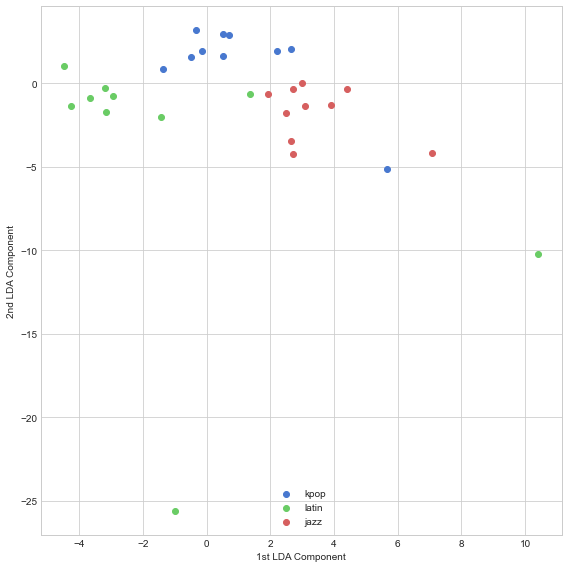

In [6]:
#Creating an instance of the LDA object, which is an object capable of learning and applying LDA from/to data.
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#lda will keep a number of components equal to numner of classes -1
lda = LinearDiscriminantAnalysis()


#This will learn LDA projection from train data
lda.fit(feat_train,lab_train)

#Now we project the data using LDA
projected_features_train = lda.transform(feat_train)
projected_features_test = lda.transform(feat_test)

#this is only for scatter plot purposes
projected_features = lda.transform(scaler.transform(features))


#Plot the distribution of the data according to the first two principle components
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 8))
    for lab_val, lab_name in zip(range(0,len(classes)),classes):
        plt.scatter(projected_features[labels==lab_val, 0],
                    projected_features[labels==lab_val, 1],
                    label=lab_name)
    plt.xlabel('1st LDA Component')
    plt.ylabel('2nd LDA Component')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

In [7]:
#Creating an instance of a SVM classifier
model_SVM = sklearn.svm.SVC(kernel='poly', C=1.0)

#training the model
model_SVM.fit(projected_features_train, lab_train)

#applying the the model on the test data (features)
lab_predict = model_SVM.predict(projected_features_test)


#print the number of misclassified samples, accuracy and complete report (using scikit learn metric tools) 
print('Number of mislabeled samples %d out of %d' % ((lab_test != lab_predict).sum(),lab_test.size))
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))

Number of mislabeled samples 3 out of 9
Accuracy: 0.6666666666666666


In [8]:
#computing a comprehensive set of performance metrics
print(sklearn.metrics.classification_report(lab_test, lab_predict))

print(sklearn.metrics.confusion_matrix(lab_test, lab_predict))

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67         3
         1.0       1.00      0.33      0.50         3
         2.0       0.60      1.00      0.75         3

    accuracy                           0.67         9
   macro avg       0.76      0.67      0.64         9
weighted avg       0.76      0.67      0.64         9

[[2 0 1]
 [1 1 1]
 [0 0 3]]


In [9]:
#displaying names of misclassified files
results = lab_test == lab_predict
for index, value in results.items():
    if value == False:
        print(filenames[index])


latin_RC0182.mid
latin_RC0928.mid
kpop_HTX0430.mid
